# CREASE for Vesicle Analysis

## Introduction

**This tutorial has been created by Ziyu Ye, Zijie Wu, and Arthi Jayaraman to accompany their publication: Ye, Z.; Wu, Z; Jayaraman, A. Computational Reverse-Engineering Analysis for Scattering Experiments (CREASE) on Vesicles Assembled from Amphiphilic Macromolecular Solutions (under review)**

In general, Computational Reverse Engineering Analysis for Scattering Experiments (CREASE) is a two step approach that combines a genetic algorithm (GA) as the first step with molecular simulations based reconstruction as the second step to determine for a given input scattering profile the structural features of assembled structures in macromolecular solutions. Structural features range from aggregate dimensions to the chain- and monomer- level packing within the aggregate. This tutorial presents CREASE for vesicles. If you use CREASE in your work, we ask that you please cite one of the relevant papers below. If you use this vesicle code, please cite References 5. 


[1] Beltran-Villegas, D. J.; Wessels, M. G.; Lee, J. Y.; Song, Y.; Wooley, K. L.; Pochan, D. J.; Jayaraman, A. Computational Reverse-Engineering Analysis for Scattering Experiments on Amphiphilic Block Polymer Solutions. *J. Am. Chem. Soc.* **2019**, 141, 14916−14930.

[2] Wessels, M. G.; Jayaraman, A. Computational Reverse-Engineering Analysis of Scattering Experiments (CREASE) on Amphiphilic Block Polymer Solutions: Cylindrical and Fibrillar Assembly. *Macromolecules* **2021**, 54, 783-796.

[3] Wessels, M. G.; Jayaraman, A. Machine Learning Enhanced Computational Reverse Engineering Analysis for Scattering Experiments (CREASE) to Determine Structures in Amphiphilic Polymer Solutions. *ACS Polymers Au* **2021**, https://doi.org/10.1021/acspolymersau.1c00015.

[4] Heil, C.; Jayaraman, A. Computational reverse-engineering analysis for scattering experiments of assembled binary mixture of nanoparticles. *ACS Materials Au* **2021**, https://doi.org/10.1021/acsmaterialsau.1c00015

[5] Ye, Z.; Wu, Z; Jayaraman, A. Computational Reverse-Engineering Analysis for Scattering Experiments (CREASE) on Vesicles Assembled from Amphiphilic Macromolecular Solutions.

This notebook presents a tutorial on how the first step of CREASE, the GA step, works in determining the structural features of the assembled structure (vesicle in this tutorial) found in macromolecular solutions from small angle scattering intensity profiles. The GA codes takes as input I(q) and finds the structural dimensions of the vesicle whose computed scattering, 𝐼𝑐𝑜𝑚𝑝(q), best matches the input I(q). The GA code presented here is applicable to vesicle structure with a core and three layers (two solvophilic layers and one solvophobic layer). But it can be adapted to other shapes and geometries by modifying sections of the code that will be highlighted as such.

The GA code for vesicles is able to determine:
1. Vesicle dimensions in core radius ($R_{core}$), the three individual layer thicknesses in the membrane that consist of the inner solvophilic A layer ($t_{Ain}$), middle solvophobic B layer ($t_{B}$), and the outer solvophilic A layer ($t_{Aput}$).
2. How the solvophilic scatterers are split between inner ($s_{Ain}$) and outer ($1-s_{Ain}$) layers.
3. Dispersity (or polydispersity) in vesicle size as implemented in the core radius dimension ($\sigma_{R}$) during I(q) calculation.

<img src="CREASE_vesicles_code_structure_dimensions.png" width=300 height=300 />

A basic understanding of how GA works and the associated technical terms(e.g. gene, generation, selection, fitness, crossover, mutation) would be helpful for following along to this tutorial. The user can find a brief introduction to GA from any of the five references listed above, especially in the original refences [1]. The [the wikipedia page of genetic algorithm](https://en.wikipedia.org/wiki/Genetic_algorithm) also offers a general overview of the GA method.

Below is the general structure showing the flow of the GA code presented in this package:

<img src="code_diagram_main1_all.png" width=600 height=600 />

## Setup python libraries

In [1]:
import crease_ga as cga
from inspect import getsource

### Model

Current "location" in the code flow diagram marked in red:

<img src="code_diagram_main2_model.png" width=600 height=600 />

Let's start with the initial arguments that the user needs to choose and input for their system. 

In the cell block below, the user needs to define the arguments that define the basic architecture of the genetic algorithm:
* number of individuals in a population ('pop_number')
* number of generations that GA runs for ('generations')
* number of binary digits used to represent each individual ('nloci')

The user chooses the above three agruments to run the GA. The choice of these three arguments will significantly affect the performance of the GA. We recommend that the user test out different combinations of these three parameters to ensure convergence to the right output. For the example, here, after multiple tests during our previous work, we recommend the following values for these arguments to produce reliable output for the input $I$(q):
* `pop_number = 80`
* `generations = 100`
* `nloci = 7`

As the computational time needed to complete the GA run increases with increasing number of individuals and generations, for the purpose of completing this tutorial within reasonable time, on a regular PC, we use the following values:
* `pop_number = 5`
* `generations = 5`
* `nloci = 7`

You should not expect to see the 'best' 𝐼𝑐𝑜𝑚𝑝(q) match the input or target $I$(q) with these settings. With larger number of individuals and generations, you can see how the GA predictions evolve over the generations to higher "fitness" structures [i.e. closer match to the input $I$(q)].

For each individual in the GA, we store information about structural features in its genome. For each of the individual's genome, the information is encoded as a seven-digit (chosen by the user as $n_{loci}$, set in this tutorial as 7) binary sequence that corresponds to the value of structural dimensions evenly distributed between the maximum and minimum bounds set by the user (minimum bound will be 0000000, and maximum 1111111). The choice of the number of binary digits will determine the precision of the final optimized structural dimensions.

*You may ask at this point - why are we encoding the parameters in a binary fashion?*
That is a great question! Actually, whether to use binary or decimal encoding has always been a topic of debate in the field of genetic algorithm. Traditional GAs tend to use binary coding (referred to as 'binary-coded GA'), but there also have been numerous applications of GA to engineering problems using "decimal coding" (often referred to as 'real-coded GA'). We happen to have been developing the algorithm following the binary coding route, but there is technically no reason why we cannot use real-coded GA for this problem. One can always rewrite our genetic operator algorithms if one wishes to use real-coded GA (more on this later)

In [2]:
m = cga.Model(pop_number = 5,
              generations = 5,
              nloci = 7)

## load_shape

<img src="code_diagram_main3_load-chem.png" width=600 height=600 />

The second set of arguments passed to the GA is done through `load_shape` and here the user chooses the assembled shape of interest. For this tutorial the shape is 'vesicle'.

**shape_params**

Regardless of the type of assembled shape (vesicles or other micelles), each shape requires the user to choose a set of shape descriptors that defines the basic morphology of the structure. In this example, we load in the `vesicle` shape, which requires the following 7 shape descriptors (specified as a list given in the following order with the `shape_params` argument):
* Number of scatterers per chain (${num}_{scatterers}$)
* Number of beads on chain ($N$)
* Density or volume fraction of beads in B layer ($\rho_B$)
* Monomer contour length' ($l_{mono,b}$） [Angstrom]
* Monomer cminontour length' ($l_{mono,a}$）[Angstrom]
* Fraction of B type monomers in chain ($fb$)
* Number of replicates ($n_{LP}$)

For vesicles assembled from amphiphilic macromolecules with solvophilic A and solvophobic B blocks, two types of scatterers (A and B, respectively) are randomly placed within the designated vesicle layer boundaries (more details to be given later). The ratio of A and B scatterers matches the composition of the amphiphilic macromolecule ( 1−𝑓𝑏 ,  𝑓𝑏 ).  We note that the scatterers could be point scatterers or scatterers with a specified diameter, as is the case in this example (for reasons described in the reference [5]). Regardless of the choice, the total number of A and B scatterers is another choice that the user has to make to balance the accuracy of the output vesicle dimensions from GA and the computational time for the 𝐼𝑐𝑜𝑚𝑝(q) calculation (more details to be given later).

NOTE: The determination of 𝐼𝑐𝑜𝑚𝑝(q) in the GA only uses the scatterer placements and these placements do NOT include any connectivity to resemble macromolecules.

In this vesicle example, the user can enter the macromolecular information about the solution that was used to obtain the scattering profile to guide the choice of number of scatterers placed in the individual candidate structure. Here for this tutorial example, we use the molecular information for a diblock copolymer with the solvophilic block A and solvophobic block B forming the vesicle bilayer. The diblock chain has total number of  𝑁 monomer beads with  𝑓𝑏  fraction of the beads in the chain being solvophobic. The packing density of the solvophobic monomor beads in the middle layer is given by $\rho_B$ and the diameters of the A an B beads (or "monomer contour length") are given by $l_{mono,a}$ and $l_{mono,b}$, respectively. The specific values used in this example are given below.

For this vesicle system example, we calculate each individual's 𝐼𝑐𝑜𝑚𝑝(q) using seven different configurations (`nLP`) of random scatterer placements to generate the averaged 𝐼𝑐𝑜𝑚𝑝(q) for that individual. Having multiple configurations of scatterer placements mitigates the chance of any one configuration of scatterer placements within the vesicle dimension from biasing the computed scattering intensity. One could also choose to replace the use of multiple (`nLP=7` in this case) placements of fewer scatterers with just one placement using a significantly higher total number of scatterers per unit volume (i.e., scatterer density) which will lead to reduced biasing one may see upon using fewer scatterers (or smaller scatterer density). We choose to use multiple different configurations of random scatterer placements in this case to incorporate the ability to capture dispersity in dimensions (more details will be found later).

For a more detailed discussion on the scatterer placement and density in the specific case of CREASE for vesicles, please see reference [5].

**Setting bounds for GA parameters**

The user also sets the maximum (`maxvalu`) and minimum (`minvalu`) bounds for each parameter (or genome) of the individual candidate structure. For the vesicle system example, the GA determines the following parameters:
* Core radius ($R_{core}$), 
* Three individual layer thicknesses in the bilayer consisting of the inner solvophilic A layer ($t_{Ain}$), middle solvophobic B layer ($t_{B}$), and the outer solvophilic A layer ($t_{Aout}$), 
* Split of the solvophilic scatterers between inner ($s_{Ain}$) and outer layers,
* Dispersity in the core radius dimension ($\sigma_{R}$).
* Background intensity as -log10($bg$)

The structural parameters (core radius and the three layer thicknesses) in the `vesicle` shape, are in length units and coded in Angstrom, and `q` is given in $A^{-1}$.

Just to reiterate, different shapes will have different sets of shape descriptors and parameters, so the aforementioned list of descriptors and their definitions only applies to the **`vesicle`** shape. It is important for the user to make sure that the shape descriptors and minimum/maximum bounds correspond to the expectation of the chosen shape.


Obviously, to properly use a shape, a user will need to understand what each value in `shape_params` (the shape descriptors) corresponds to, and what each value specified in `minvalu` and `maxvalu` refer to (the dimension parameters GA is going to predict based on the input I(q) profile). These pieces of information, as explained in the previous cell, can also be retrieved by calling the docstring of the `scatterer_generator` class of each shape. For example, for shape _vesicle_,

In [3]:
import crease_ga.shapes.vesicle.scatterer_generator as sg
print(sg.scatterer_generator.__doc__)


    The wrapper class for vesicle shape. Default length unit: Angstrom.
    
    Shape-specific descriptors (shape_params):
    ------------------------------------------
    num_scatterers: 
        Number of scatterers per chain (num_scatterers). Default: 24
    N: 
        Number of beads on chain. Default: 54
    rho_B:
        Density or volume freaction of beads in B layer. Default: 0.5
    lmono_b:
        Monomer contour length (diameter) of chemistry B. Default: 50.4 A
    lmono_a:
        Monomer contour length (diameter) of chemistry A. Default: 50.4 A
    fb: 
        Fraction of monomers of chemistry B. fa = 1-fb. Default: 0.55
    nLP:
        Number of replicates for each individual. Default: 7

    Input parameters to be predicted:
    --------------------------------
    R_core:
        Core radius. Default [min,max]: [50 A, 400 A]
    t_Ain:
        Thickness of inner A layer. Default [min,max]: [30 A, 200 A]
    t_B:
        Thickness of B layer. Default [min,max]: 

In [4]:
m.load_shape(shape='vesicle', 
                 shape_params=[24,54,0.5,50.4,50.4,0.55,7], #num_scatterers,N,rho_B,lmono_b,lmono_a,fb,n_LP 
                 minvalu = (50, 30, 30, 30, 0.1, 0.0, 0.1), #lower bounds: R_core,t_Ain,t_B,t_Aout,s_Ain,sigma_R,bg 
                 maxvalu = (400, 200, 200, 200, 0.45, 0.45, 4)) # upper bounds: R_core,t_Ain,t_B,t_Aout,s_Ain,sigma_R,-log10(bg)

The final preparation step we need to do before the model is prepared for the GA iteration is to specify the \"input\" $I_{exp}(q)$, i.e. the input I(q) profile we want to analyze to obtain relevant structural dimensions.

### load_iq

<img src="code_diagram_main4_load-iq.png" width=600 height=600 />

Back to the main GA code after creating the initial population of individuals. Now let's read in the input "experimental" scattering intensity profile $I_{exp}(q)$, which in this example is stored in a text file that has the $q$ and $I(q)$ information. 

For the example here, our $I_{exp}(q)$ is an *in silico* $I(q)$ created from a target vesicle structure where all dimensions and dispersity in size are known and thus the GA can be tested on it to see how well the code performs in getting each parameter.

After loading in the target $I_{exp}(q)$, the user can set the upper and lower bounds on the $q$-range over which the GA will determine the best candidate vesicle structure. 

Run the cell block below to see how loading the input $I_{exp}(q)$ is implemented in the code.

In [5]:
print(getsource(cga.Model.load_iq))

    def load_iq(self,input_file_path,q_bounds=None):
        loadvals = np.loadtxt(input_file_path)
        self.qrange_load = loadvals[:,0]
        IQin_load = loadvals[:,1]
        self.IQin_load=np.true_divide(IQin_load,np.max(IQin_load))
        #TODO: highQ and lowQ needs to be able to be dynamically set
        if q_bounds == None:
            self.qrange = self.qrange_load
            self.IQin = self.IQin_load
        else:
            lowQ = q_bounds[0]
            highQ = q_bounds[1]
            self.IQin = self.IQin_load[ np.where(self.qrange_load>=lowQ)[0][0]:np.where(self.qrange_load>=highQ)[0][0] ]
            self.qrange = self.qrange_load[ np.where(self.qrange_load>=lowQ)[0][0]:np.where(self.qrange_load>=highQ)[0][0] ]
            

        baseline = self.IQin[0]
        self.IQin = np.true_divide(self.IQin,baseline)
        self.IQin_load = np.true_divide(self.IQin_load,baseline)



And now let's load the target $I_{exp}(q)$ for this tutorial and have a look at what we just loaded, the qs (`qrange`) and the I(q)s (`IQin`):

In [6]:
m.load_iq('../IEXP_DATA/Itot_disper_10_Ain12_B6_Aout12_nLP7_dR0.2.txt')
m.qrange

array([0.003     , 0.00499038, 0.00698077, 0.00897115, 0.01096154,
       0.01295192, 0.01494231, 0.01693269, 0.01892308, 0.02091346,
       0.02290385, 0.02489423, 0.02688462, 0.028875  , 0.03086538,
       0.03285577, 0.03484615, 0.03683654, 0.03882692, 0.04081731,
       0.04280769, 0.04479808, 0.04678846, 0.04877885, 0.05076923,
       0.05275962, 0.05475   , 0.05674038, 0.05873077, 0.06072115,
       0.06271154, 0.06470192, 0.06669231, 0.06868269, 0.07067308,
       0.07266346, 0.07465385, 0.07664423, 0.07863462, 0.080625  ,
       0.08261538, 0.08460577, 0.08659615, 0.08858654, 0.09057692,
       0.09256731, 0.09455769, 0.09654808, 0.09853846, 0.10052885])

In [7]:
m.IQin

array([1.0000000e+00, 6.2860837e-01, 2.9286080e-01, 8.7949510e-02,
       1.2834420e-02, 9.2236500e-03, 2.0607380e-02, 2.2230630e-02,
       1.5156950e-02, 7.5634500e-03, 3.5948300e-03, 2.7369700e-03,
       3.0672500e-03, 3.3229100e-03, 3.1583600e-03, 2.7294400e-03,
       2.3245000e-03, 2.1397100e-03, 2.1655100e-03, 2.2329100e-03,
       2.2011700e-03, 2.0914600e-03, 2.0090300e-03, 1.9766300e-03,
       1.9166600e-03, 1.7834700e-03, 1.6330700e-03, 1.5407800e-03,
       1.5069200e-03, 1.4766600e-03, 1.4189700e-03, 1.3519000e-03,
       1.3046900e-03, 1.2831100e-03, 1.2720800e-03, 1.2557800e-03,
       1.2297400e-03, 1.2004100e-03, 1.1775700e-03, 1.1654200e-03,
       1.1587200e-03, 1.1480600e-03, 1.1295100e-03, 1.1076500e-03,
       1.0882500e-03, 1.0701900e-03, 1.0475400e-03, 1.0185700e-03,
       9.8931000e-04, 9.6721000e-04])

Sometimes, a user might only be interested in fitting to a portion of the q range. This can be done by setting the `q_bounds` argument of `load_iq` to `[lower_bound,higher_bound]`. For example:

In [8]:
m.load_iq('../IEXP_DATA/Itot_disper_10_Ain12_B6_Aout12_nLP7_dR0.2.txt',q_bounds=[0.005,0.1])
print('qrange',m.qrange)
print('IQin',m.IQin)

qrange [0.00698077 0.00897115 0.01096154 0.01295192 0.01494231 0.01693269
 0.01892308 0.02091346 0.02290385 0.02489423 0.02688462 0.028875
 0.03086538 0.03285577 0.03484615 0.03683654 0.03882692 0.04081731
 0.04280769 0.04479808 0.04678846 0.04877885 0.05076923 0.05275962
 0.05475    0.05674038 0.05873077 0.06072115 0.06271154 0.06470192
 0.06669231 0.06868269 0.07067308 0.07266346 0.07465385 0.07664423
 0.07863462 0.080625   0.08261538 0.08460577 0.08659615 0.08858654
 0.09057692 0.09256731 0.09455769 0.09654808 0.09853846]
IQin [1.         0.30031165 0.0438243  0.031495   0.07036578 0.07590852
 0.05175479 0.02582609 0.01227488 0.00934563 0.01047341 0.01134638
 0.01078451 0.00931992 0.00793722 0.00730624 0.00739433 0.00762448
 0.0075161  0.00714148 0.00686002 0.00674938 0.00654461 0.00608982
 0.00557627 0.00526113 0.00514552 0.00504219 0.0048452  0.00461619
 0.00445498 0.0043813  0.00434363 0.00428798 0.00419906 0.00409891
 0.00402092 0.00397943 0.00395656 0.00392016 0.00385682 0.0037

You can see that the first two and last one pairs of q and I(q) values have been excluded because they are out of the bounds that we have set.

## Adaptation parameters

Another set of parameters we have not covered are the adaptation parameters. As the GA selects the individuals that gets to move on to the next generation, the selected individual can be modified through the crossover and mutation procedures. The selected individual undergoes crossover with probability $PC$ and mutation with probability $PM$, and the initial values of these two parameters are chosen below. The user also sets the upper and lower bounds for these two parameters ($PC_{max}$, $PC_{min}$, $PM_{max}$, $PM_{min}$). During the GA, $PC$ and $PM$ control the relative rate of exploration vs exploitation updated based on the reciprocal genetic diversity parameter, $GDM$, given by

$$ GDM = \frac{\text{min error of population}}{\text{average error of population}} $$

which also has upper and lower bounds ($GDM_{max}$, $GDM_{min}$) set by the user. $GDM$ should be between 0 and 1. The form of the error will be described in more details in a later section. The adjustment factor $kGDM$ is also set by the user that is used to adjust the genetic diversity of the population.

These values can depend on the shape and need to be tested if the user applies the GA to a new shape. For this tutorial, we are using the adaptation parameters that have been optimized for the vesicle example here. To learn more about the choosing these adaptation parameters, please read referefence [1].

Run the cell block below to see the values of the adaptation parameters being used:

In [9]:
for d in dir(m.adaptation_params):
    if not '__' in d:
    
        print(d,getattr(m.adaptation_params,d))

gdmmax 0.85
gdmmin 0.005
kgdm 1.1
pc 0.6
pcmax 1
pcmin 0.5
pm 0.001
pmmax 0.25
pmmin 0.006
update <bound method adaptation_params.update of <crease_ga.adaptation_params.adaptation_params object at 0x7f0b97d16820>>


## Solve

<img src="code_diagram_main5_solve.png" width=600 height=600 />

Now having all of the user defined parameters and chosen shape for the structure, we can start running the GA. This is done by calling the `solve` instance method of the `Model` class. Let's see the source code by running the block below:

In [10]:
print(getsource(cga.Model.solve))

    def solve(self,verbose = True,backend = 'debye',fitness_metric = 'log_sse',output_dir='./'):
        pop = utils.initial_pop(self.popnumber, self.nloci, self.numvars)
        for gen in range(self.generations):    
            if backend == 'debye':
                pacc,gdm,elitei,IQid_str = self.fitness(pop,gen,output_dir,metric='log_sse')
                IQid_str = np.array(IQid_str)
            pop = self.genetic_operations(pop,pacc,elitei)
            self.adaptation_params.update(gdm)
            
            if verbose:
                figsize=(4,4)
                fig, ax = plt.subplots(figsize=(figsize))
                ax.plot(self.qrange_load,self.IQin_load,color='k',linestyle='-',ms=8,linewidth=1.3,marker='o')
                ax.plot(self.qrange,IQid_str[elitei].transpose(),color='fuchsia',linestyle='-',ms=8,linewidth=2)#,marker='o')
                plt.xlim(0.001,0.1)
                plt.ylim(2*10**(-5),20)
                plt.xlabel(r'q, $\AA^{-1}$',fontsize=20)
      

### Initial_pop

<img src="code_diagram_main6_initial-pop.png" width=600 height=600 />

The first thing `solve` does is to call the instance method `initial_pop` to create the first generation of individuals for the GA iteration. `Initial_pop` takes in the number of indiviuals in a population and generates individual candidate structures based on the bounds set for each of the GA parameters. It then outputs the population information (`pop`) back to the GA code.

To see the source code of this function, run following block:

In [11]:
print(getsource(cga.utils.initial_pop))

def initial_pop(popnumber, nloci, numvars):
    '''
    Generate a generation of (binary) chromosomes.
    
    Parameters
    ----------
    popnumber: int
        Number of individuals in a population.
    nloci: int
        Number of binary bits to represent each parameter in a chromosome.
    numvars: int
        Number of parameters in a chromosome.
        
    Return
    ------
    pop: np.array of size (`popnumber`,`nloci`*`numvars`)
        A numpy array of binary bits representing the entire generation, 
        with each row representing a chromosome.
    '''
    pop=np.zeros((popnumber,nloci*numvars))
    for i in range(popnumber):
        for j in range(nloci*numvars):
            randbinary=np.random.randint(2)
            pop[i,j]=randbinary
    return pop



To read the docstring of this function, run following block:

In [12]:
print(cga.utils.initial_pop.__doc__)


    Generate a generation of (binary) chromosomes.
    
    Parameters
    ----------
    popnumber: int
        Number of individuals in a population.
    nloci: int
        Number of binary bits to represent each parameter in a chromosome.
    numvars: int
        Number of parameters in a chromosome.
        
    Return
    ------
    pop: np.array of size (`popnumber`,`nloci`*`numvars`)
        A numpy array of binary bits representing the entire generation, 
        with each row representing a chromosome.
    


Run the block below to see what a binary representation for an example of 5 individuals in the population looks like:

In [13]:
pop = cga.utils.initial_pop(popnumber = 5, nloci = 7, numvars = 7)
print(pop)

[[0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0.
  1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
  0.]
 [0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
  0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
  0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.
  1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1.
  1.]
 [1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.
  0.]
 [1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.
  1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
  1.]]


Starting with the inital population of individuals (0-th generation) generated from `Initial_pop`, we need to determine the "fitness" for each individual, that is, how well does the individual's computed $I_{comp}$(q) matches the target "experimental" $I_{exp}$(q). To facilitate the fitness calculation in the GA code, we call the `fitness` function from the main GA code. The fitness calculation requires several input arguments from the main GA code that is passed in binary form, which it then "decodes" to get the values of all of the GA parameters for each of the individuals in the population. 

So before talking about the `fitness` in more details, first let's take a look at the `decode` function.

### decode

<img src="code_diagram_main9_decode.png" width=600 height=600 />

Run the cell block below to see the source code of this function.

In [14]:
print(getsource(cga.utils.decode))

def decode(pop, indiv, nloci, minvalu,maxvalu):
    import numpy as np
    minvalu = np.array(minvalu)
    maxvalu = np.array(maxvalu)
    deltavalu=maxvalu-minvalu
    nvars=len(minvalu)
    valdec=np.zeros(nvars)
    param=np.zeros(nvars)
    #   decodes from binary to values between max and min
    for j in range(nvars): 
        n=nloci
        for i in range(j*nloci,(j+1)*nloci):
            n=n-1
            valdec[j]+=pop[indiv,i]*(2**n)
            
        param[j]=minvalu[j]+np.true_divide((deltavalu[j])*(valdec[j]),2**nloci)
    return param



To see an example of the decoded parameter values for an individual generated using `initial_pop`, run the following cell block:

In [15]:
pop = cga.utils.initial_pop(popnumber = 5, nloci = 7, numvars = 7)
print('binary',pop[0])
print('decimal',cga.utils.decode(pop,0,
                                 nloci=7,
                                 minvalu=[50, 30, 30, 30, 0.1, 0.0, 0.1],
                                 maxvalu=[400, 200, 200, 200, 0.45, 0.45, 4]))

binary [1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 1.]
decimal [2.63281250e+02 1.53515625e+02 1.62812500e+02 1.18984375e+02
 2.23046875e-01 3.86718750e-02 2.08046875e+00]


Now let's take a closer look at what happens in `fitness` and how fitness is calculated for each individual in the population.
### fitness

<img src="code_diagram_main7_fitness.png" width=600 height=600 />

First let's look at the source code:

In [16]:
print(getsource(cga.Model.fitness))

    def fitness(self,pop,generation,output_dir,metric='log_sse'):
        tic = time.time()
        cs=10
        F1= open(output_dir+'results_'+str(generation)+'.txt','w')
        F1.write('#individual...all params...error\n')
        np.savetxt(output_dir+'population_'+str(generation)+'.txt',np.c_[pop])
        
        fitn=np.zeros(self.popnumber)
        fitnfr=np.zeros(self.popnumber)
        fit=np.zeros(self.popnumber)
        qfin=self.qrange[-1]
        IQid_str=[]
        params=[]
        for val in range(self.popnumber):
            sys.stdout.write("\rGen {:d}/{:d}, individual {:d}/{:d}\n".format(generation+1,self.generations,val+1,self.popnumber))
            sys.stdout.flush()
            param=utils.decode(pop, val, self.nloci, self.minvalu, self.maxvalu) # gets the current structure variables
            params.append(param)

            ### calculate computed Icomp(q) ###
            IQid=self.scatterer_generator.converttoIQ(self.qrange, param)

            err=0
   





The core of the `fitness` function is given by the following set of equations

$$ fitness = X(sse_{max}-see)+Y $$

$$ sse = \sum w\left[log\left(\frac{I_{exp}(q)}{I_{comp}(q)}\right)\right]^2 $$

$$ X = (cs-1)\frac{max(sse_{max}-sse)}{max(sse_{max}-sse)-average(sse_{max}-sse)} $$

$$ Y = (1-X)average(sse_{max}-sse) $$

where $I_{exp}$(q) is the input scattering intensity profile read in from the main GA code, $I_{comp}$(q) is the computed scattering intensity profile for the individual (to be discussed in more details later on), $sse$ is the sum of squared errors between $I_{comp}$(q) and $I_{exp}$(q) and $X$ and $Y$ serve to prevent low fitness solutions from being prematurely eliminated in the population.

In this example, we choose the form of the error function, `sse`, as the sum of the log difference of squared errors where the weighting factor, $w$, accounts for the log-scale spacing of the q values. For more details on the choice of this form for the error function for the systems explored with CREASE, see references [1-5].

We also note that user may choose to use a different form of sse as long as the choice of error function ensures appropriate error weighting in the range of q explored. For studies where the target $I_{exp}$(q) comes from experimental scattering with an associated uncertainty at each q, a commonly used formulation is $\chi^{2}$ to account for the errors during fitting optimization. For example, SASVIEW uses $\chi^{2}$ to quantify the goodness of fit by taking the direct difference squared between the computed and target dataset over the fitted q range weighted by the squared error at each q. If the error associated with each q is known, $\chi^{2}$ can similarly be implemented into the fitness function in CREASE to account for uncertainty in I(q) at each q. We plan to incorporate $\chi^{2}$ as another option for fitness metric in a future release coming soon.

SASVIEW implementation of $\chi_{2}$: https://www.sasview.org/docs/user/qtgui/Perspectives/Fitting/residuals_help.html

## converttoIQ

<img src="code_diagram_main10_convert.png" width=600 height=600 />

In order to perform the fitness calculation, the key piece of information needed is the computed scattering intensity, $I_{comp}$(q), which `fitness` function gets from the `converttoIQ` function. The `converttoIQ` function is what ties the different shapes to the GA code during implementation. Each shape will have its own `converttoIQ` that takes as input a list of q values (`qrange`) and a list of shape-specific parameters (the "gene"), and outputs a list of $I_{comp}$(q) value corresponding to the input `qrange`. So let's now take a look at how the `vesicle` shape determines the the computed scattering intensity, $I_{comp}$(q), from the input parameters.

### converttoIQ for vesicle

<img src="code_diagram_sub1_all.png" width=600 height=600 />

**Equations to get computed scattering intensity**

The `converttoIQ` function calculates the computed scattering intensity $I_{comp}$(q) from the intra-vesicle structure factor $\omega$(q) (see `LPOmega`) using the following set of equations from scatterers placed within the boundaries of the candidate individual structure:

$$ I_{comp}(q) = F_{M}^2(q)S_{MM}(q) + I_{background} $$

$F^2_{M}(q)$ is the form factor given by
$$ F^2_{M}(q) = \sum_{\alpha\in{A,B}} \sum_{\beta\in{A,B}} b_{\alpha}b_{\beta}F_{GA, \alpha}(q)F_{GA, \beta}(q)\omega(q) $$

where $b_{A}$ and $b_{B}$ are the scattering length densities for A and B scatterers, $F_{GA, \alpha}(q)$ and $F_{GA, \beta}$ are the spherical form factors for A and B scatterers (see `LPFbead`), $\omega(q)$ is the intra-vesicle structure factor (see `LPOmega`) and $S_{MM}(q) = 1$ is the vesicle-vesicle structure factor for dilute solutions. For concentration solutions where the structure factor will not be equal 1, we can combine the approach described along with the structure factor CREASE code (work in Reference [4]); we will be adding this capability into this package in the near future.


**Scatterer placements**

As mentioned in an above section, the essential information for the calculation of $I_{comp}$(q) is the scatterer placements and the user can directly choose the total number of scatterers ($n_{tot}$) to be placed in the vesicle to control the scatterer density. For an assembled structure formed from molecules with two (or more) chemistries, the user also inputs the relative compositions for the chemical groups as $f_{a}$ and $f_{b}$ ($f_{c}$, etc.). The choice of the scatterer density appropriate to the assembled structure studied is chosen by the user. One way to obtain an estimate of $n_{tot}$, as shown in this tutorial example for vesicles, is through the molecular information of the molecule that make up the assembled structure.

In this vesicle system example, let us determine the number of scatterers for placing within each layer in the vesicle wall:

1. Get the core radius ($R_{core}$) as the averaged core radius ($R_{core, 0}$) plus the variation in core radius for each replicate ($\sigma_{R}$).
$$ R_{core} = R_{core, 0} + \sigma_{R} $$

2. Calculate the volume of the solvophobic B layer for the individual:
$$ V_{B} = \frac{4}{3}\pi \left[ (R_{core}+t_{Ain}+t_{B})^3 - (R_{core}+t_{Ain})^3 \right] $$

3. Get the number of chains/molecules in the structure:
$$ N_{chain} = \frac{\rho_{B}V_{B}}{Nf_{B}M_{B}} $$

4. The number of A ($n_{A}$) and B ($n_{B}$) scatterers are determined using the composition ($f_{A}$, $f_{B}$) of the respective block in the chain/molecule are given by
$$ n_{A} = N_{chain}n_{sct}f_{A} = N_{chain}n_{sct}(1-f_{B}) $$
$$ n_{B} = N_{chain}n_{sct}f_{B} $$
where $n_{sct}$ is the number of scatterers per chain/molecule selected by the user.

5. The number A scatterers the inner ($n_{Ain}$) and outer ($n_{Aout}$) solvophilic layers are given by
$$ n_{Ain} = n_{A}s_{Ain} $$
$$ n_{Aout} = n_{A}(1-s_{Ain}) $$
where $s_{Ain}$ is a parameter in the GA that gives the fraction of chains/molecules in the inner solvophilic layer. 

**The $s_{Ain}$ parameter, which is determined by the GA, is a feature of the vesicle assembly that cannot be readily determined through traditional fittings of scattering profiles with core-multi-shell model, which is found in SASVIEW package [ https://www.sasview.org/docs/user/models/core_multi_shell.html ]. The addition and determination of $s_{Ain}$ in CREASE for vesicles offers molecular insight to the distribution of solvophilic monomers between the inner and outer layers in the vesicle wall**. For more details on the `vesicle` shape scatterer generation and parameter determination, please read reference [5].

Now using the set of information for the vesicle dimensions and the number of scatterers that goes into each layer in the vesicle wall, we can generate the scatterer positions for the vesicle shape by calling the `genLP` and `gen_layer` functions.

### genLP and gen_layer

<img src="code_diagram_sub2_gen.png" width=600 height=600 />

In this example, we get the coordinates for all scatterers in the vesicle with three layers in the wall. 

For the vesicle system example presented here, the `gen_layer` function defined in `gen_layer` places $n_{size}$ number of random point scatterers within a spherical shell defined by the inner ($r_{in}$) and outer ($r_{out}$) radii, where $n_{size}$ is the corresponding number of A or B type scatterers determined in `converttoIQ` for the given shell or layer.

`gen_LP` then calls the `gen_layer` function for each individual layers in the vesicle (in this example, the two solvophilic A and one solvophobic B layers that make up the vesicle membrane) and gathers the scatterer coordinates for the complete vesicle to be passed back to `converttoIQ` for use in calculating the intra-vesicle structure factor $\omega(q)$.

In [17]:
import crease_ga.shapes.vesicle.scatterer_generator as sg
print(getsource(sg.gen_layer))
print(getsource(sg.genLP))

def gen_layer(rin, rout, nsize):
        R = 1.0

        phi = np.random.uniform(0, 2*np.pi, size=(nsize))
        costheta = np.random.uniform(-1, 1, size=(nsize))
        u = np.random.uniform(rin**3, rout**3, size=(nsize))

        theta = np.arccos( costheta )
        r = R * np.cbrt( u )

        x = r * np.sin( theta ) * np.cos( phi )
        y = r * np.sin( theta ) * np.sin( phi )
        z = r * np.cos( theta )

        return( x, y, z )

def genLP(Rcore, dR_Ain, dR_B, dR_Aout, sigmabead, nAin, nAout, nB):  
        # core radius, inner A layer thickness, B layer thickness, outer A layer thickness, 
        # bead diameter, # of inner A beads, # of outer A beads, # of B beads

        ntot = nAin+nB+nAout
        power = 2
        r = np.zeros((1, 3, ntot))
        types = np.zeros((ntot))

        ### Create configuration for each replicate with dispersity ###
        for step in range(0, 1):
            ### Populate A inner Layer ###
            x, y, z = gen_layer(Rcore, Rc

### converttoIQ for vesicle

**Back to getting the computed $I_{comp}$(q)**

Now that we have the scatterer positions from the `gen_LP` function, `converttoIQ` can call the `LPOmega` function and pass the scatterer coordinates to it to get the intra-vesicle structure factor, $\omega(q)$. Recall the set of equations to get $I_{comp}$(q):

$$ I_{comp}(q) = F_{M}^2(q)S_{MM}(q) + I_{background} $$

$F^2_{M}(q)$ is the form factor given by
$$ F^2_{M}(q) = \sum_{\alpha\in{A,B}} \sum_{\beta\in{A,B}} b_{\alpha}b_{\beta}F_{GA, \alpha}(q)F_{GA, \beta}(q)\omega(q) $$

So let us take a look at how $\omega(q)$ is calculated in `LPOmega` and how the spherical form factors $F_{GA, \alpha}(q)$ and $F_{GA, \beta}$ for A and B scatterers are calculated in `LPFbead` (note that in this example, A and B scatterers are spheres with the same finite size and so we only need to calculate one spherical form factor as $F_{GA, \alpha}(q)$ = $F_{GA, \beta}$).

### LPOmega

<img src="code_diagram_sub3_omega.png" width=600 height=600 />

Here we calculate the intra-vesicle structure factor as
$$ \omega(q) = \left< \frac{1}{N_{A}+N_{B}} \sum^{N_{A}+N_{B}}_{i=1} \sum^{N_{A}+N_{B}}_{j=1} \frac{\sin{qr_{ij}}}{qr_{ij}} \right> $$

where $N_{A}$ and $N_{B}$ are the number of scatterers in the two solvophilic A and one solvophobic B layers, respectively, and $r_{ij}$ is the distance between the pair of scatterers $i$ and $j$ in the vesicle assembly determined from the previous step in `genLP`.

**NOTE: The above is a computationally intensive calculation as it scales with the number of scatterers.**

There are alternative faster options for directly obtaining $I_{comp}(q)$ for a given set of structural dimensions include using machine learning methods. We direct you to reference [3] where one such alternative option using artificial neural networks was developed.

To see the sourcecode for this function, run the cell block below:

In [18]:
print(getsource(sg.LPOmega))

def LPOmega(qrange, nAin, nAout, nB, r):                # qvalues number_of_B number_of_A scatterer_coordinates
    Ntot=nAin+nB+nAout                                  # Total number of scatterers to loop through
    omegaarrt=np.zeros((1,len(qrange)))                 # initiating array
    
    omegaarr=np.zeros((1,len(qrange)))              # initiating array
    rur=r[0,:,:]                                 # selects      
    for i in range(Ntot-1):                         # loops through index and all further indexes to prevent double counting 
        x = np.square(rur[0,i]-rur[0,(i+1):])
        y = np.square(rur[1,i]-rur[1,(i+1):])
        z = np.square(rur[2,i]-rur[2,(i+1):])
        rij = np.sqrt(np.sum([x,y,z],axis=0))       # calculates the distances
        rs = rij[:,np.newaxis]                      # reshapes array for consistency
        Q = qrange[np.newaxis,:]                    # reshapes array for consistency
        vals = ne.evaluate("sin(Q*rs)/(Q*rs)")      # ne i

### LPFbead

<img src="code_diagram_sub4_bead.png" width=600 height=600 />

The **spherical form factor amplitude** is calculated as

$$ F_{GA, \alpha}(q) = 3 \frac{ \sin(q0.5\sigma_{GA, \alpha}) - q0.5\sigma_{GA, \alpha}\cos(q0.5\sigma_{GA, \alpha}) }{(q0.5\sigma_{GA, \alpha})^3} $$

where $\alpha$ indicates A or B scatterer and $\sigma_{GA, \alpha}$ is the scatterer diameter.

To see the sourcecode for this function, run the following cell block:

In [19]:
print(getsource(sg.LPFbead))

def LPFbead(qrange, sigmabead):
    '''
    Compute the spherical form factor given a range of q values.
    
    Parameters:
    ----------
    qrange: numpy.array
        array of values in q-space to compute form factor for.
    sigmabead: float
        diameter of the sphere.
    
    Return:
    ----------
    Fqb: numpy.array
        array of values of the spherical form factors (F(q)) computed at q-points listed in qrange.
    '''
    
    R=np.true_divide(sigmabead,2)
    QR=np.multiply(qrange,R)
    Fqb=np.multiply(np.true_divide(np.sin(QR)-np.multiply(QR,np.cos(QR)),np.power(QR,3)),3)  

    return Fqb



### converttoIQ for vesicles

<img src="code_diagram_main10_convert.png" width=600 height=600 />

**Back again to getting the computed scattering intensity $I_{comp}$(q)**

Now that we have both $\omega(q)$ and $F_{GA, \alpha}(q)$ from the `LPOmega` and `LPFbead` functions, all that is left to do is to put together all of the pieces together to get $I_{comp}$(q) as:

$$ I_{comp}(q) = F_{M}^2(q)S_{MM}(q) + I_{background} $$

$F^2_{M}(q)$ is the form factor given by
$$ F^2_{M}(q) = \sum_{\alpha\in{A,B}} \sum_{\beta\in{A,B}} b_{\alpha}b_{\beta}F_{GA, \alpha}(q)F_{GA, \beta}(q)\omega(q) $$

and `converttoIQ` will output the computed scattering intensity $I_{comp}$(q) as `IQid` in the code.

Run the cell block below to see the sourcecode for this function:

In [20]:
print(getsource(sg.scatterer_generator.converttoIQ))

    def converttoIQ(self, qrange, param):
        '''
        Calculate computed scattering intensity profile.

        Parameters
        ----------
        qrange: int
            q values.
        param: int
            Decoded parameters.

        Return
        ------
        IQid: A numpy array holding I(q).
        '''
        # q values, decoded parameters, 
        # number of repeat units per chain, fraction of B beads per chain, core density, 
        # scatterer diameter, molar mass of B chemistry, 
        # length of A chemistry bond, length of B chemistry bond, 
        # number of scatterers per chain, # of replicates, stdev in Rcore size
        sigmabead = self.sigmabead
        N = self.N
        fb = self.fb
        rho_B = self.rho_B
        MB = self.MB
        lmono_a = self.lmono_a
        lmono_b = self.lmono_b
        num_scatterers = self.num_scatterers
        nLP = self.nLP
        
        IQid=np.zeros((len(qrange)))      #initiates array for output IQ

 

### fitness

<img src="code_diagram_main7_fitness.png" width=600 height=600 />

Having gone through getting the computed scattering intensity, we are finally back to the `fitness` function, which if the user recalls is given by the following set of equations

$$ fitness = X(sse_{max}-see)+Y $$

$$ sse = \sum w\left[log\left(\frac{I_{exp}(q)}{I_{comp}(q)}\right)\right]^2 $$

$$ X = (cs-1)\frac{max(sse_{max}-sse)}{max(sse_{max}-sse)-average(sse_{max}-sse)} $$

$$ Y = (1-X)average(sse_{max}-sse) $$

where we get the $I_{exp}$(q) from reading in the input scattering data file and $I_{comp}$(q) from the `converttoIQ` function, and in this example we choose the scaling constant $cs$ to be 10.

Thus the `fitness` function will calculate the fitness value for each of the individuals. Also within the `fitness` function, we calculate the selection probability for each individual, $P_{select}$, that is proportional to its fitness value.
We then store the selection information (`pacc`) for all of the individuals in the population and pass it back to the main GA code where individuals will be selected to move on to the next generation.

To see the sourcecode of this function, run the following cell block:

In [21]:
print(getsource(cga.Model.fitness))

    def fitness(self,pop,generation,output_dir,metric='log_sse'):
        tic = time.time()
        cs=10
        F1= open(output_dir+'results_'+str(generation)+'.txt','w')
        F1.write('#individual...all params...error\n')
        np.savetxt(output_dir+'population_'+str(generation)+'.txt',np.c_[pop])
        
        fitn=np.zeros(self.popnumber)
        fitnfr=np.zeros(self.popnumber)
        fit=np.zeros(self.popnumber)
        qfin=self.qrange[-1]
        IQid_str=[]
        params=[]
        for val in range(self.popnumber):
            sys.stdout.write("\rGen {:d}/{:d}, individual {:d}/{:d}\n".format(generation+1,self.generations,val+1,self.popnumber))
            sys.stdout.flush()
            param=utils.decode(pop, val, self.nloci, self.minvalu, self.maxvalu) # gets the current structure variables
            params.append(param)

            ### calculate computed Icomp(q) ###
            IQid=self.scatterer_generator.converttoIQ(self.qrange, param)

            err=0
   

In this example, the `fitness` function also provides useful information like which one of the individuals performed the best ("elite"), in terms of having its computed $I_{comp}$(q) matching the input $I_{exp}$(q), the second best ("second"), averagely ("average") and the worst ("minfit") that are stored and saved for the user (in `fitness_vs_gen.txt`).

Next, a new generation of individuals will be selected based on the fitnesses of the current generation. That is done in the `genetic_operations` function.

### genetic_operations

<img src="code_diagram_main8_genetic-ops.png" width=600 height=600 />

**Selection Process: Crossover, Mutation and Elitism**

Now that we have the fitness value for each individual in the population, the GA will need to select the candidates for the next generation, and this iterative process is continued until the maximum number of generations (set by the user during the beginning of the main GA code) is reached. As each of the GA parameters is encoded as a seven-digit binary sequence, the genetic operations (crossover, mutation) performed on selected individuals is done in binary form.

*Crossover*

During crossover, two individuals in the population are selected as "parents" and their traits are mixed to produced a new "offspring" individual to be included in the next generation. Each parent individual is selected with probability $PC$ as and the offspring has traits randomly chosen from its two parent individuals. 

*Mutation*

An individual is selected for mutation with probability $PM$, where one of its traits is randomly selected to be changed within that parameter's range of values.

*Elitism*

The best individual in the generation is always included in the population for next generation.

The probabilities of crossover $PC$ and mutation $PM$ are adjusted during the iterative process over the generations during a GA run to help prevent premature convergence to local minima (with the `adaptation_params.update` function during `Model.solve`). When $GDM$ drops below the lower bound, then $PC$ is increased by the factor $kGDM$ (here chosen to be 1.1) and $PM$ is decreased by the same factor $kGDM$ to reduced the genetic diversity. If $GDM$ is close to 1, then $PC$ is decreased by the factor $kGDM$ and $PM$ is increased by the factor $kGDM$ to increase the genetic diversity.

Run the block below to see the source code:

In [22]:
print(getsource(cga.Model.genetic_operations))

    def genetic_operations(self,pop,pacc,elitei):
        popn = np.zeros(np.shape(pop))
        cross = 0
        mute = 0
        pc = self.adaptation_params.pc
        pm = self.adaptation_params.pm
        
        for i in range(self.popnumber-1):

            #####################    Crossover    ####################

            #Selection based on fitness
            testoff=random.random()
            isit=0
            npart1=1
            for j in range(1,self.popnumber):
                if (testoff>pacc[j-1])&(testoff<pacc[j]):
                    npart1=j

            testoff=random.random()
            isit=0
            npart2=1
            for j in range(self.popnumber):
                if (testoff>=pacc[j-1])&(testoff!=pacc[j]):
                    npart2=j

            #Fit parents put in array popn

            popn[i,:]=pop[npart1,:]


            testoff=random.random()
            loc=int((testoff*(self.numvars-1))*self.nloci)
            if loc==0:
              

After selecting the individuals in the population that get to move on to the next generation, we once again calculate the fitness for each individual in the new generation. Then the selection and fitness processes are repeated until the end of the GA run.

## Running the GA

We have finally gone through all the elements of `Model.solve`, and now let's get it to work!
(**Note**: you can specify the `output_dir` argument for the directory to which you would like to save all the output files. The directory needs to already exist before you run this line!)

Gen 1/5, individual 1/5
Gen 1/5, individual 2/5
Gen 1/5, individual 3/5
Gen 1/5, individual 4/5
Gen 1/5, individual 5/5
Generation time: 852.591s
Generation best fitness: 3.9459
Generation gdm: 0.541
Generation best parameters [[1.37500000e+02 1.64140625e+02 1.34921875e+02 1.68125000e+02
  3.76171875e-01 8.78906250e-02 3.23828125e+00]]
pc 0.6
#crossovers 1
pm 0.001
#mutations 0




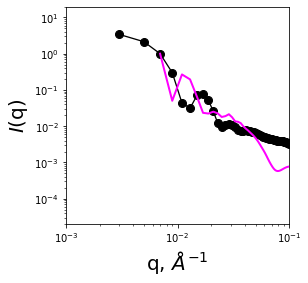

Gen 2/5, individual 1/5
Gen 2/5, individual 2/5
Gen 2/5, individual 3/5
Gen 2/5, individual 4/5
Gen 2/5, individual 5/5
Generation time: 227.755s
Generation best fitness: 3.9006
Generation gdm: 0.530
Generation best parameters [[1.37500000e+02 1.64140625e+02 1.34921875e+02 1.68125000e+02
  3.76171875e-01 8.78906250e-02 3.23828125e+00]]
pc 0.6
#crossovers 3
pm 0.006
#mutations 1




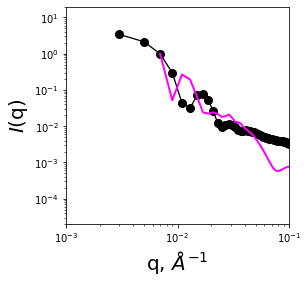

Gen 3/5, individual 1/5
Gen 3/5, individual 2/5
Gen 3/5, individual 3/5
Gen 3/5, individual 4/5
Gen 3/5, individual 5/5
Generation time: 303.854s
Generation best fitness: 3.9251
Generation gdm: 0.415
Generation best parameters [[1.37500000e+02 1.64140625e+02 1.34921875e+02 1.68125000e+02
  3.76171875e-01 8.78906250e-02 3.23828125e+00]]
pc 0.6
#crossovers 2
pm 0.006
#mutations 0




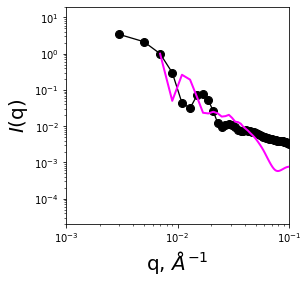

Gen 4/5, individual 1/5
Gen 4/5, individual 2/5
Gen 4/5, individual 3/5
Gen 4/5, individual 4/5
Gen 4/5, individual 5/5
Generation time: 294.921s
Generation best fitness: 3.8821
Generation gdm: 0.369
Generation best parameters [[1.37500000e+02 1.64140625e+02 1.34921875e+02 1.68125000e+02
  3.76171875e-01 8.78906250e-02 3.23828125e+00]]
pc 0.6
#crossovers 1
pm 0.006
#mutations 0




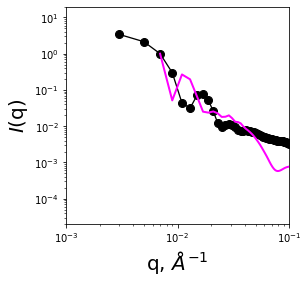

Gen 5/5, individual 1/5
Gen 5/5, individual 2/5
Gen 5/5, individual 3/5
Gen 5/5, individual 4/5
Gen 5/5, individual 5/5
Generation time: 283.641s
Generation best fitness: 3.8998
Generation gdm: 0.371
Generation best parameters [[1.37500000e+02 1.64140625e+02 1.34921875e+02 1.68125000e+02
  3.76171875e-01 8.78906250e-02 3.23828125e+00]]
pc 0.6
#crossovers 3
pm 0.006
#mutations 2




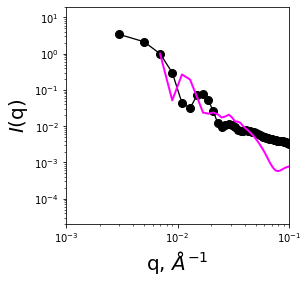

In [23]:
'''uncomment this to create a new directory'''
#!mkdir test_output_1 

m.solve(verbose=True,output_dir='./test_output_1/')

If all of the cell blocks of code above have been run properly, then performing the GA on the small number of individuals and generations will produce the output dimensions and $I_{comp}$(q) that can be compared to the target dimensions of the structure that provided the input $I_{exp}$(q) as shown below.

Data output from each generation has been saved to files under the directory specified by `output_dir`. Check out `results` for all the indiviuals at each generation, and `fitness_vs_gen` for how the fitness of the generation in general evolves. 

After you are done, check out the notebook under this directory named [workflow_simplified](./workflow_simplified.ipynb), to see how each step works once we have taken out these in-depth explanations, how the entire GA is actually set up and run with only several lines of codes.

Good luck!

<img src="short_run_output.png" width=300 height=300 />

### GA for Vesicles with Larger Population Size and Number of Generations

If the above codes for the example vesicle system in this tutorial have been successfully run, then the user should be able to see the best individual's $I_{comp}$(q) plotted against the input $I_{exp}$(q). With the small population size (`popnumber = 5`) and number of generations (`generations = 5`) used in this tutorial example, the resulting $I_{comp}$(q) of the best individual structure is unlikely to be a good match to the input $I_{exp}$(q). As mentioned previously, using a small number of individuals and generations in this example is to purely to keep the calculations computationally feasible. To produce better matches to the input $I_{exp}$(q) one would need to use significantly higher number of individuals and generations on a more powerful computer.

Shown below is an example of the kind of GA determined results that we can expect when we use the GA on the same input $I_{exp}$(q) but with a much larger population size and number of generations:

`popnumber = 80`

`generations = 100`

<img src="crease_tutorial_fig_Icomp-vs-gen.png" width=300 height=300 />

**Figure 1**: *CREASE analysis on an example vesicle with the target dimensions of small core with thin B layer (shown schematically). $I_{comp}$(q) of the best individual (colored lines) from all generations in one example GA run (with dispersity) compared with the input in silico  $I_{exp}$(q) (open circles). Progression from the initial generation to the final generation is shown with increasingly warmer colors.*

From the best individual's $I_{comp}$(q) over multiple generations, we can see that increasing the population size and number of generation gradually drives the GA determined vesicle structure towards that of the target structure (**Figure 1**). Because our input  $I_{exp}$(q) was generated in silico from known target dimensions, we can also make a direct comparison of the GA determined vesicle dimensions to the known target dimensions. For comparison we also provide the dimensions determined through the traditional fitting of the data with the core-multi-shell model in SASVIEW.

<img src="crease_tutorial_fig_dim-ga-vs-sasview.png" width=300 height=300 />

**Figure 2**: *GA determined dimensions of relevant vesicle features at the end of 100 generations for the cases where dispersity in dimensions is not accounted for in the GA step (blue triangles) and when dispersity is incorporated into the GA (orange squares). The target dimensions of the in silico Iexp(q) are shown as open circles with 20% dispersity in the core radius (Rcore) dimensions. SASVIEW fitting results using the core-multi-shell model (grey stars) are offset to the right of the target dimensions.*

As discussed during the tutorial, GA for vesicles can incorporate the effect of dispersity in the dimensions of the assembly into the calculation of the individual's $I_{comp}$(q) and this dispersity is determined as one of the GA results given as $\sigma_{R}$ in this example systems where dispersity is incorporated in the core radius dimension. **Figure 2** shows how the GA with (i.e. GA searches and optimizes for $\sigma_{R}$) and without (i.e. GA sets $\sigma_{R} = 0$) dispersity performs in getting the vesicle structural dimensions of core radius ($R_{core}$), each layer thickness ($t_{A,in}$, $t_{B}$, $t_{A,out}$) and total vesicle diameter size ($D_{vesicle}$). We can see that with an appropriate population size and number of generations, the GA is able to accurately capture the target structure's dimensions. Additionally, while the analytical fitting to a core-multi-shell model using SASVIEW can also determine these structural dimensions, GA for vesicle is able to inform the user how the molecules are split between the inner and outer layers of the vesicle wall ($s_{Ain}$), a piece of molecular information not available if core-multi-shell model is used instead. The GA determined parameter $s_{Ain}$ gives the fraction of molecules in the vesicle assembly that occupies the inner layer of the vesicle walls. For this example system, the target structure has 20% of the molecules in the assembly occupying the inner layer of the vesicle wall and the GA is able to determine $s_{Ain}$ as 28%, well matching the target value.

For more detailed discussions on CREASE for vesicles and its application to different vesicle sizes and high dispersity, the user can refer to reference [5].